# Classification with Quantum Kernel Mixtures

This notebook illustrates how to use [Quantum kernel Mixtures](https://github.com/fagonzalezo/quakemix) for classification.

In [1]:
'''
Create a 2 moons dataset 
'''
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Create a 2 moons dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


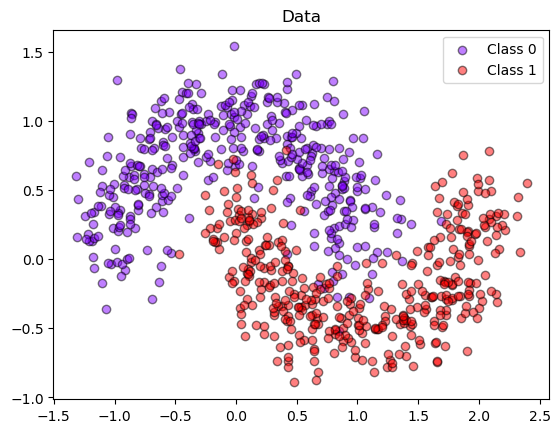

In [2]:
# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")
    plt.title("Data")

# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    print(np.min(preds), np.min(ZZ))
    plt.contourf(XX, YY, ZZ, 100, cmap = plt.cm.coolwarm, vmin= 0, vmax=1)
    plt.colorbar()
    CS = plt.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    plt.clabel(CS, inline=1, fontsize=10)
    plt.xlabel("x")
    plt.ylabel("y")

def gen_pred_fun(clf):
    def pred_fun(X):
        return clf.predict(X)[:, 1]
    return pred_fun

plot_data(X_train, y_train)

In [3]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers
from keras import losses
from keras import metrics
import tensorflow as tf

import qkm
from importlib import reload
reload(qkm);

## A shallow model 

We use the QKMClassModel to train a shallow model that directly apply a QKM inference layer to the raw data. 

In [6]:
from qkm.tf.models.qkm_class_model import QKMClassModel


encoded_size = 2
dim_y = 2
encoder = lambda x: x
n_comp = 10

qkm_model = QKMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=0.1)

# train the classifier
qkm_model.compile(optimizer=optimizers.Adam(lr=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])
idx = np.random.randint(X_train.shape[0], size=n_comp)
qkm_model.init_components(X_train[idx], 
                          np.eye(2)[y_train[idx]],
                          init_sigma=True)
qkm_model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=0)


/Users/fgonza/miniforge3/envs/tf2_py39/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2023-06-13 16:31:58.789314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 6/79 [=>............................] - ETA: 1s 

2023-06-13 16:32:17.407928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 1s 6ms/step
7.167944e-06 7.167944e-06


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
2023-06-13 16:32:18.158385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.14986614882946014
Test accuracy: 0.9449999928474426
Train loss: 0.1514570266008377
Train accuracy: 0.9487500190734863
Sigma: 0.6804827451705933


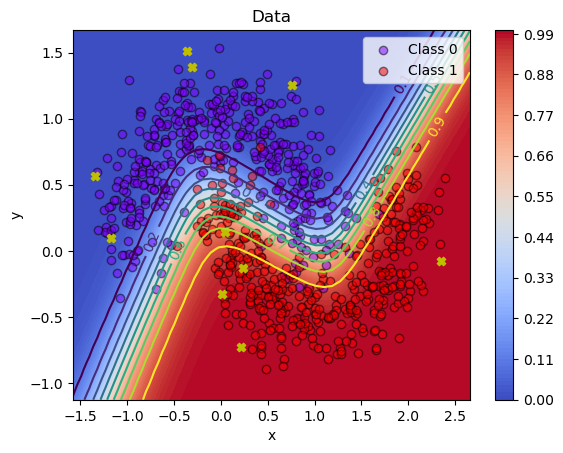

In [7]:
plot_decision_region(X, gen_pred_fun(qkm_model))
plot_data(X_train, y_train)
# plot the prototypes
plt.scatter(qkm_model.qkm.c_x.numpy()[:, 0], qkm_model.qkm.c_x.numpy()[:, 1], c='y', marker='X')
# Evaluate the classifier
score = qkm_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
score = qkm_model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print(f'Sigma: {qkm_model.kernel.sigma.numpy()}')


The model learn a joint QKM that can be seen as a set of prototypes, which are pairs of x and y values. The prototypes are shown in the plot above as yellow crosses. The model also learn a set of weights that are used to combine the prototypes to make predictions.

## MLE training 

We use another alternative to train the model, maximum likelihood estimation (MLE) of the joint probabilities of the input and the output. For this we use the QKMJointDenEstModel class. It uses a QKMProjLayer that calculates the projection of a sample to the space defined by the Layer QKM. The value of this projection can be converted in a probability density multiplying it by the normalizing constants of the corresponding kernel. The class QKMJointDenEstModel uses a Cross Product Kernel (CrossProductKernelLayer) that combines an RBF kernel for the inputs (RBFKernelLayer) and a Cosine kernel (CosineKernelLayer) for the outputs.

In [8]:
# join X and y using a one-hot encoding for y
Xy_train = np.concatenate((X_train, np.eye(2)[y_train]), axis=1)
Xy_test = np.concatenate((X_test, np.eye(2)[y_test]), axis=1)

/Users/fgonza/miniforge3/envs/tf2_py39/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


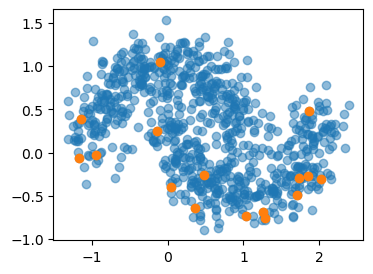

2023-06-13 16:38:57.074454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [9]:
from qkm.tf.models import QKMJointDenEstModel
reload(qkm.tf.models)

dim_x = 2
dim_y = 2
sigma = 0.1
n_comp = 16 
qkm_mle = QKMJointDenEstModel(dim_x=dim_x, dim_y=dim_y, sigma=sigma, n_comp=n_comp)

optimizer = tf.keras.optimizers.Adam(lr=5e-3)
qkm_mle.compile(optimizer=optimizer)
# kqmd_model2.predict(Xy_train[:1]) # initialize the model
idx = np.random.randint(Xy_train.shape[0], size=n_comp)
qkm_mle.init_components(Xy_train[idx], sigma=sigma) 


# Plot initial prototypes
centroids = qkm_mle.qkmproj.c_x.numpy()
fig = plt.figure(figsize=(4, 3))
plt.scatter(Xy_train[:, 0], Xy_train[:, 1], alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o')
plt.show()

qkm_mle.fit(Xy_train, epochs=100, verbose=0, batch_size=100)


Now we create a classifier model based on the density estimation model. 

In [10]:
qkm_model2 = QKMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=0.1)

qkm_model2.qkm.c_x.assign(qkm_mle.qkmproj.c_x[:, 0:2])
qkm_model2.qkm.c_y.assign(qkm_mle.qkmproj.c_x[:, 2:4])
qkm_model2.qkm.c_w.assign(qkm_mle.qkmproj.c_w)
qkm_model2.kernel.sigma.assign(qkm_mle.kernel_x.sigma)

qkm_model2.compile(optimizer=optimizers.Adam(lr=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])


 7/79 [=>............................] - ETA: 0s 

2023-06-12 22:16:17.472326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 1s 7ms/step
2.3207345e-08 2.3207345e-08


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
2023-06-12 22:16:18.406393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.06848423182964325
Test accuracy: 0.9700000286102295
Train loss: 0.08382146805524826
Train accuracy: 0.9674999713897705
Sigma: 0.28054919838905334


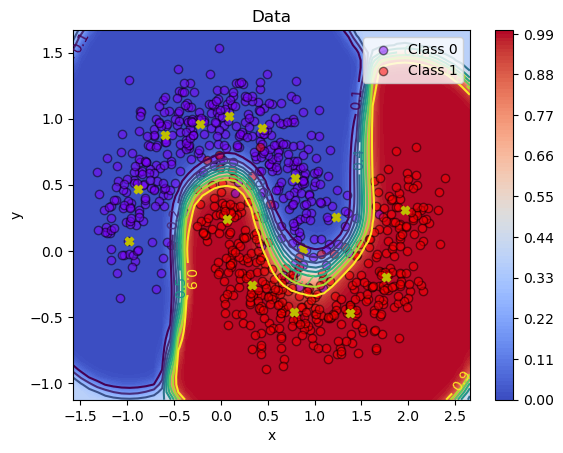

In [15]:
plot_decision_region(X, gen_pred_fun(qkm_model2))
plot_data(X_train, y_train)
# plot the prototypes
comp_w = tf.abs(qkm_model2.qkm.c_w) + 1e-6
comp_w = comp_w / tf.reduce_sum(comp_w)
prototypes = qkm_model2.qkm.c_x.numpy()[comp_w > 0.01]
plt.scatter(prototypes[:, 0], prototypes[:, 1], 
             c='y', marker='X')
# Evaluate the classifier
score = qkm_model2.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
score = qkm_model2.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print(f'Sigma: {qkm_model2.kernel.sigma.numpy()}')


The above visualization shows the decision boundary of the classifier model along with the prototypes of the model. Only prototypes with a weight greater than 0.01 are shown. The prototypes are shown as yellow crosses. Because of the likelihood maximization, prototypes are distributed evenly in the input space to maximize the density of the input samples. The classification performance in on par with the discriminative model.

## MNIST example

An example using the mnist dataset. In addition to perform classification we will show how to perform generation.

In [11]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers
from keras import losses
from keras import metrics
import qkm
import tensorflow as tf

from importlib import reload
reload(qkm);

In [12]:
# Create a dataset from mnist using tf
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.


# reshape the data to include a channel dimension
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# Partition the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

def display_imgs(x, y=None):
    if not isinstance(x, (np.ndarray, np.generic)):
      x = np.array(x)
    plt.ioff()
    n = x.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n, 1))
    if y is not None:
      fig.suptitle(np.argmax(y, axis=1))
    for i in range(n):
      axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
      axs.flat[i].axis('off')
    plt.show()
    plt.close()
    plt.ion()


We define a deep encoder that will be used to map input images to a low-dimensional latent space.

In [14]:
tfkl = tf.keras.layers

def create_encoder(input_shape, base_depth, encoded_size):
    encoder = tf.keras.Sequential([
        tfkl.InputLayer(input_shape=input_shape),
        tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
        tfkl.Conv2D(base_depth, 5, strides=1,
                    padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(base_depth, 5, strides=2,
                    padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=1,
                    padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=2,
                    padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                    padding='valid', activation=tf.nn.leaky_relu),
        tfkl.Dense(encoded_size,
                activation=None),#, activity_regularizer=tf.keras.regularizers.l2(1e-3)),
        #tfk.layers.LayerNormalization(),
        tfkl.Flatten(),
    ])
    return encoder

The classifier model (QKMClassModel) receives as input the encoder, and applies it before applying the QKM inference layer.

In [15]:
# Define the encoder
input_shape = (28, 28, 1)
base_depth = 32
encoded_size = 2
encoder = create_encoder(input_shape, base_depth, encoded_size)

# Create a classifier model
dim_y = 10
n_comp = 64

qkm_mnist = QKMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=0.1)

# initialize the prototypes using random samples from the training set
idx = np.random.randint(X_train.shape[0], size=n_comp)
qkm_mnist.init_components(X_train[idx], tf.one_hot(y_train[idx], 10), 
                          init_sigma=True, sigma_mult=10)

print(f'Sigma: {qkm_mnist.kernel.sigma.numpy()}')

# Compile the model
qkm_mnist.compile(optimizer=optimizers.Adam(lr=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])

Sigma: 0.13260217010974884


/Users/fgonza/miniforge3/envs/tf2_py39/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
# Train the model
qkm_mnist.fit(X_train, y_train, validation_data=(X_val[:1000], y_val[:1000]), epochs=10, batch_size=128, verbose=1)
print(f'Final Sigma: {qkm_mnist.kernel.sigma.numpy()}')


Epoch 1/10


2023-06-13 16:46:04.518775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - ETA: 0s - loss: 1.3539 - sparse_categorical_accuracy: 0.5188

2023-06-13 16:46:09.789443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 6s 53ms/step - loss: 1.3539 - sparse_categorical_accuracy: 0.5188 - val_loss: 0.6940 - val_sparse_categorical_accuracy: 0.7420
Epoch 2/10
94/94 [==============================] - 4s 45ms/step - loss: 0.4116 - sparse_categorical_accuracy: 0.8812 - val_loss: 0.3113 - val_sparse_categorical_accuracy: 0.9120
Epoch 3/10
94/94 [==============================] - 4s 41ms/step - loss: 0.2141 - sparse_categorical_accuracy: 0.9378 - val_loss: 0.2864 - val_sparse_categorical_accuracy: 0.9230
Epoch 4/10
94/94 [==============================] - 4s 41ms/step - loss: 0.1595 - sparse_categorical_accuracy: 0.9532 - val_loss: 0.2672 - val_sparse_categorical_accuracy: 0.9210
Epoch 5/10
94/94 [==============================] - 4s 41ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.9632 - val_loss: 0.2492 - val_sparse_categorical_accuracy: 0.9360
Epoch 6/10
94/94 [==============================] - 4s 41ms/step - loss: 0.0984 - sparse_categorical_accuracy: 0.971

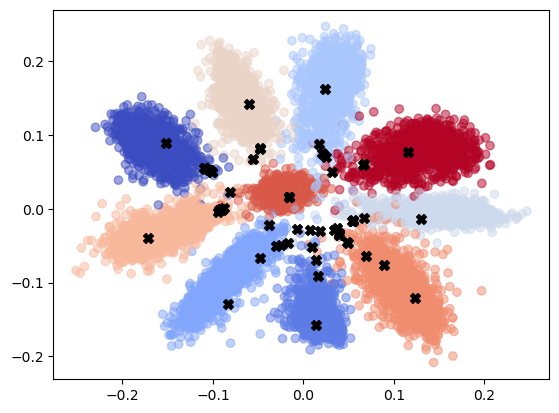

In [17]:
# Visualize the points in the feature space
plt.scatter(encoder(X_train)[:, 0], encoder(X_train)[:, 1], alpha=0.5, c=y_train, cmap=plt.cm.coolwarm)

# plot the prototypes
plt.scatter(qkm_mnist.qkm.c_x.numpy()[:, 0], qkm_mnist.qkm.c_x.numpy()[:, 1], c='k', marker='X', s=50)
plt.show()

The figure above show training samples mapped to the latent space with different colors according to the class. The prototypes are shown as black crosses. Note that the prototypes do not cover all the areas of the different classes in the latent space, rather they are positioned to maximize the classification performance.

In [18]:
# Evaluate the classifier
score = qkm_mnist.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
score = qkm_mnist.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print(f'Sigma: {qkm_mnist.kernel.sigma.numpy()}')

Test loss: 0.148119255900383
Test accuracy: 0.961899995803833
Train loss: 0.03637140244245529
Train accuracy: 0.9903333187103271
Sigma: 0.02951982244849205


Now we will train a density estimation model using the QKMJointDenEstModel class and keeping the encoder fix. This model maximizes the joint likelihood of inputs and outputs. The goal is to obtain more representative prototypes, since the prototypes learned using the classification model are not representative of the data distribution, since them are optimized to maximize the classification accuracy.

/Users/fgonza/miniforge3/envs/tf2_py39/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


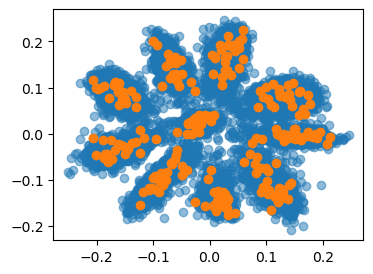

Sigma: 0.02951982244849205
Epoch 1/20


2023-06-13 16:54:11.259858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 2s 13ms/step - loss: 1.2376
Epoch 2/20
120/120 [==============================] - 1s 11ms/step - loss: 1.1974
Epoch 3/20
120/120 [==============================] - 1s 10ms/step - loss: 1.1890
Epoch 4/20
120/120 [==============================] - 1s 11ms/step - loss: 1.1804
Epoch 5/20
120/120 [==============================] - 1s 11ms/step - loss: 1.1764
Epoch 6/20
120/120 [==============================] - 1s 10ms/step - loss: 1.1780
Epoch 7/20
120/120 [==============================] - 1s 10ms/step - loss: 1.1747
Epoch 8/20
120/120 [==============================] - 1s 11ms/step - loss: 1.1761
Epoch 9/20
120/120 [==============================] - 1s 12ms/step - loss: 1.1732
Epoch 10/20
120/120 [==============================] - 1s 11ms/step - loss: 1.1700
Epoch 11/20
120/120 [==============================] - 1s 10ms/step - loss: 1.1705
Epoch 12/20
120/120 [==============================] - 1s 11ms/step - loss: 1.1698
Epoch 13/20
120/120 [===

In [21]:
# join X and y using a one-hot encoding for y
Xy_train = np.concatenate((encoder(X_train), np.eye(10)[y_train]), axis=1)

dim_x = encoded_size
sigma = qkm_mnist.kernel.sigma.numpy()
n_comp = 256
qkm_mle_mnist = QKMJointDenEstModel(dim_x=dim_x, dim_y=dim_y, sigma=sigma, n_comp=n_comp)

optimizer = tf.keras.optimizers.Adam(lr=5e-3)

# kqmd_model2.predict(Xy_train[:1]) # initialize the model
idx = np.random.randint(Xy_train.shape[0], size=n_comp)
qkm_mle_mnist.init_components(Xy_train[idx], sigma=sigma) 


# Plot initial prototypes
centroids = qkm_mle_mnist.qkmproj.c_x.numpy()
fig = plt.figure(figsize=(4, 3))
plt.scatter(Xy_train[:, 0], Xy_train[:, 1], alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o')
plt.show()

qkm_mle_mnist.compile(optimizer=optimizers.Adam(lr=1e-3))

print(f'Sigma: {qkm_mle_mnist.kernel_x.sigma.numpy()}')

qkm_mle_mnist.fit(Xy_train, epochs=20, verbose=1, batch_size=100)

print(f'Final Sigma: {qkm_mle_mnist.kernel_x.sigma.numpy()}')



Now we use the parameters learned by the Maximum Likelihood model to create a QKM classifier. This classifier is not trained, but it is initialized with the parameters learned by the MLE model.

In [22]:
qkm_mnist2 = QKMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=0.1)

qkm_mnist2.qkm.c_x.assign(qkm_mle_mnist.qkmproj.c_x[:, 0:2])
qkm_mnist2.qkm.c_y.assign(qkm_mle_mnist.qkmproj.c_x[:, 2:])
qkm_mnist2.qkm.c_w.assign(qkm_mle_mnist.qkmproj.c_w)
qkm_mnist2.kernel.sigma.assign(qkm_mle_mnist.kernel_x.sigma)


# Compile the model
qkm_mnist2.compile(optimizer=optimizers.Adam(lr=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])

# Evaluate the classifier
score = qkm_mnist2.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
score = qkm_mnist2.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print(f'Sigma: {qkm_mnist2.kernel.sigma.numpy()}')

2023-06-13 16:55:54.618840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.2145879864692688
Test accuracy: 0.9643999934196472
Train loss: 0.030669184401631355
Train accuracy: 0.9914166927337646
Sigma: 0.016848964616656303


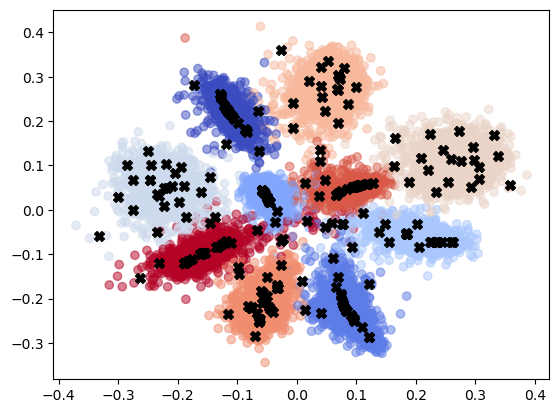

In [47]:
# Visualize the points in the feature space
plt.scatter(encoder(X_train)[:, 0], encoder(X_train)[:, 1], alpha=0.5, c=y_train, cmap=plt.cm.coolwarm)

# plot the prototypes
plt.scatter(qkm_mnist2.qkm.c_x.numpy()[:, 0], qkm_mnist2.qkm.c_x.numpy()[:, 1], c='k', marker='X', s=50)
plt.show()

## Generator model

We can build a generator taking advantage of the symmetry of the QKM layer. Basically we change the role of the x-prototypes and the y-prototypes. The entry to the model will be a 10D vector that represents probability distribution of the digits to generate . The output of the QKM layer will be a probability distribution on the latent space. We can sample from this distribution to generate new samples that we will decode to obtain the generated digit. First we will train a decoder.

In [31]:

def create_decoder(base_depth, encoded_size):
    decoder = tf.keras.Sequential([
        tfkl.InputLayer(input_shape=[encoded_size]),
        tfkl.Reshape([1, 1, encoded_size]),
        tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                            padding='valid', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                            padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                            padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                            padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                            padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                            padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                    padding='same', activation=None),
    ])
    return decoder

decoder = create_decoder(base_depth, encoded_size)
inputs = tf.keras.layers.Input(shape=input_shape)
ae_model = tf.keras.Sequential([inputs,
                            encoder,
                            decoder                            
                           ])
encoder.trainable = False

ae_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
            loss=losses.BinaryCrossentropy(from_logits=True))

ae_model.fit(X_train, X_train, epochs=20, batch_size=32, verbose=0)

2023-06-13 16:58:26.351711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Let's plot some generated digits. The digits generated from the autoencoder are fuzzy because of the small dimension of the latent space. 

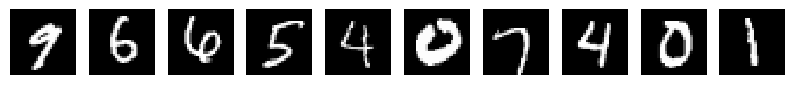

2023-06-13 17:01:01.510893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 338ms/step


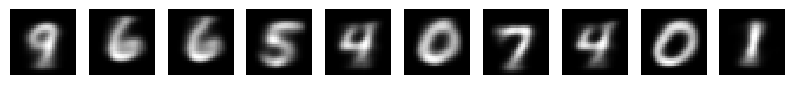

In [32]:
display_imgs(X_test[20:30])
prediction = ae_model.predict(X_test[20:30])

prediction = tf.nn.sigmoid(prediction)
display_imgs(prediction)

Now we define the generator model. It receives a 10D vector that represents the probability distribution of the digits to generate. The output of the QKM layer is a probability distribution on the latent space. We can sample from this distribution to generate new samples that we will decode to obtain the generated digit. 

In [34]:
from qkm.tf.layers import CosineKernelLayer, QKMLayer

def create_generator_model(clf_model):
        inputs_gen = Input(shape=(10,))
        kernel_gen = CosineKernelLayer()
        qkm_gen = QKMLayer(kernel=kernel_gen, 
                                   dim_x=10, 
                                   dim_y=clf_model.encoded_size, 
                                   n_comp=clf_model.n_comp)
        qkm_gen.c_x.assign(clf_model.qkm.c_y)
        qkm_gen.c_y.assign(clf_model.qkm.c_x)
        qkm_gen.c_w.assign(clf_model.qkm.c_w)
        rho_y_gen = qkm.tf.utils.pure2dm(inputs_gen)
        rho_x_gen = qkm_gen(rho_y_gen)
        gen_model = Model(inputs_gen, rho_x_gen)
        return gen_model

gen_model = create_generator_model(qkm_mnist2)
gen_model.compile()

2023-06-13 17:12:56.491428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


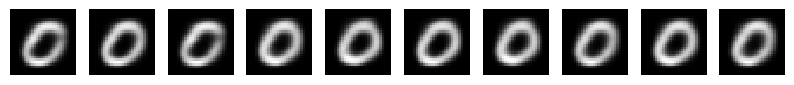

2023-06-13 17:12:57.133705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


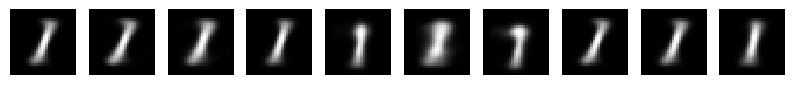

2023-06-13 17:12:57.658509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


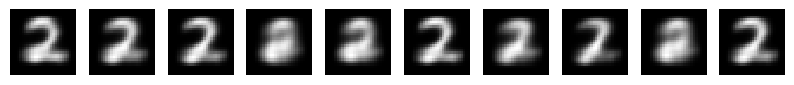

2023-06-13 17:12:58.226324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


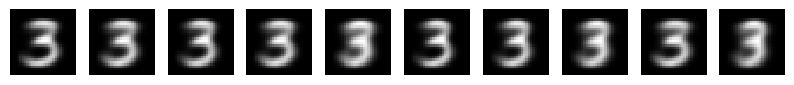

2023-06-13 17:12:58.744302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


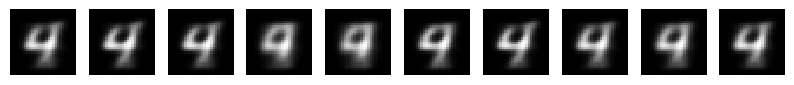

2023-06-13 17:12:59.492433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


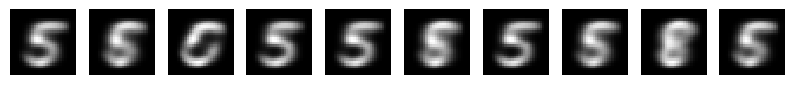

2023-06-13 17:13:00.043485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


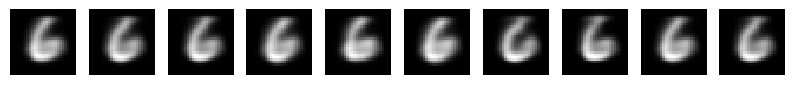

2023-06-13 17:13:00.567671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


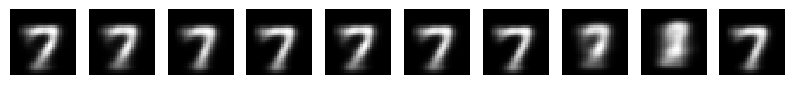

2023-06-13 17:13:01.119363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


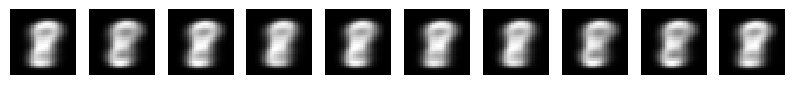

2023-06-13 17:13:01.649403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


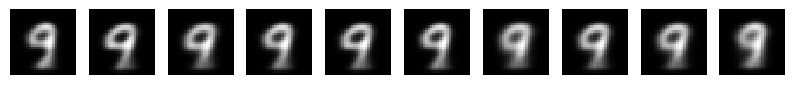

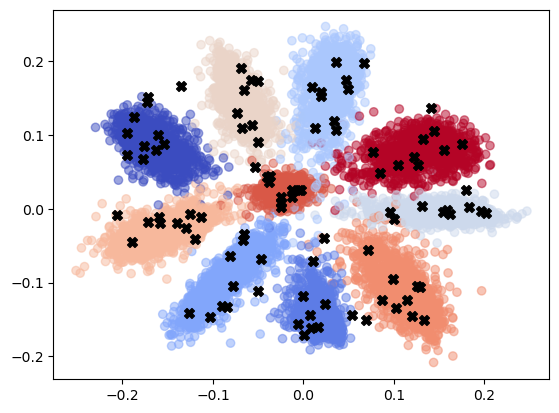

In [37]:
# Generate a set of distributions from the model for each digit
distribs = qkm.tf.utils.dm2distrib(gen_model(tf.eye(10)), sigma=qkm_mnist2.kernel.sigma * 1.5)
# Sample from the distributions
samples = []
for i in range(10):
    sample = distribs[i].sample(10).numpy()
    samples.append(sample)
    # Show the decoded images
    decoded_imgs = decoder(sample)
    decoded_imgs = tf.nn.sigmoid(decoded_imgs)
    display_imgs(decoded_imgs)

# plot the samples in the feature space
samples = np.concatenate(samples)
plt.scatter(encoder(X_train)[:, 0], encoder(X_train)[:, 1], alpha=0.5, c=y_train, cmap=plt.cm.coolwarm)
plt.scatter(samples[:, 0], samples[:, 1], c='k', marker='X', s=50)


Now we will generate digits from a label distribution that is a mixture of two digits. We will generate digits that are a mixture of 0 and 1. 

2023-06-13 17:19:18.386169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


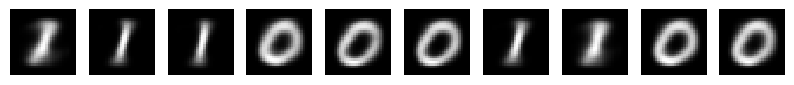

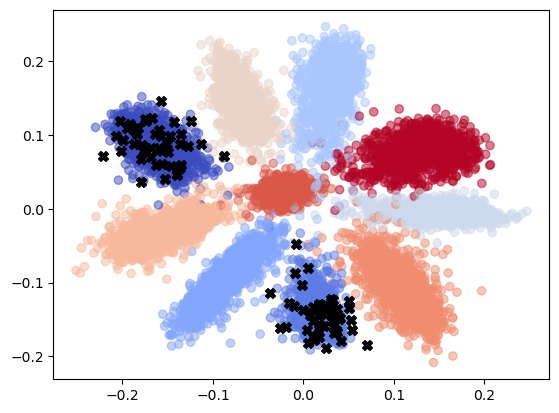

In [41]:
# Generate a set of distributions from the model for each digit
y_distrib = np.zeros((1,10))
y_distrib[0, 0] = 1 / np.sqrt(2)
y_distrib[0, 1] = 1 / np.sqrt(2)
x_distrib = qkm.tf.utils.dm2distrib(gen_model(y_distrib), sigma=qkm_mnist2.kernel.sigma * 1.5)[0]
# Sample from the distributions
sample = x_distrib.sample(100).numpy()
# Show the decoded images
decoded_imgs = decoder(sample[:10])
decoded_imgs = tf.nn.sigmoid(decoded_imgs)
display_imgs(decoded_imgs)

# plot the samples in the feature space
plt.scatter(encoder(X_train)[:, 0], encoder(X_train)[:, 1], alpha=0.5, c=y_train, cmap=plt.cm.coolwarm)
plt.scatter(sample[:, 0], sample[:, 1], c='k', marker='X', s=50)
